In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel()




Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-05-07 13:42:37,383 [INFO] WRITING LOG OUTPUT TO /Users/demir/.cellpose/run.log
2025-05-07 13:42:37,385 [INFO] 
cellpose version: 	4.0.2.dev5+g636f0ee 
platform:       	darwin 
python version: 	3.10.17 
torch version:  	2.6.0
2025-05-07 13:42:37,426 [INFO] ** TORCH MPS version installed and working. **
2025-05-07 13:42:37,428 [INFO] >>>> using CPU
2025-05-07 13:42:37,434 [INFO] >>>> using CPU
2025-05-07 13:42:38,580 [INFO] >>>> loading model /Users/demir/.cellpose/models/cpsam


In [2]:
file_name = f"/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/tif_deneme_1.tif"
img = io.imread(file_name) # (9, 4, 1024, 1024)
print(f'img       : {img.shape}')

# NUCLEI
img_nuclei = img[:, 0, :, :]
# img_nuclei = img_nuclei[6, :, :]
print(f'Nuclei    : {img_nuclei.shape}')

# NUCLEI
img_aggregate = img[:, 2, :, :]
# img_aggregate = img_aggregate[6, :, :]
print(f'Aggregate : {img_aggregate.shape}')

# CELL BODY
img_cellbody = img[:, 3, :, :]
# img_cellbody = img_cellbody[6, :, :]
print(f'Cell body : {img_cellbody.shape}')


2025-05-07 13:42:45,810 [INFO] reading tiff with 36 planes


100%|██████████| 36/36 [00:00<00:00, 508.69it/s]

img       : (9, 4, 1024, 1024)
Nuclei    : (9, 1024, 1024)
Aggregate : (9, 1024, 1024)
Cell body : (9, 1024, 1024)


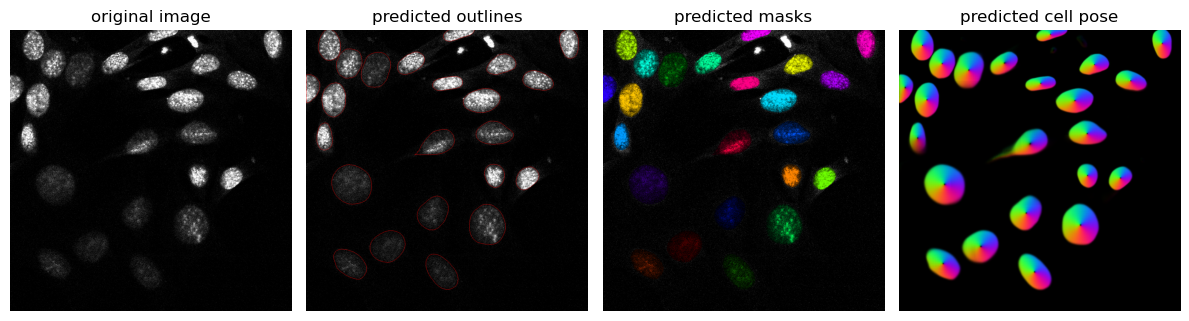

In [28]:
masks_nuclei, flows_nuclei, styles_nuclei = model.eval(
                                                        img_nuclei,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=30,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_nuclei, masks_nuclei, flows_nuclei[0])
plt.tight_layout()
plt.show()
# 3 min runtime batch 32
# 1:30 min runtime - batch 8

In [29]:
# Kaç hücre bulundu?
num_cells = masks_nuclei.max()
print(f"Toplam hücre sayısı: {num_cells}")


Toplam hücre sayısı: 23


In [4]:
masks_cellbody, flows_cellbody, styles_cellbody = model.eval(
                                                        img_cellbody,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=100,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_cellbody, masks_cellbody, flows_cellbody[0])
plt.tight_layout()
plt.show()

# 16 sec - batch 8

2025-05-07 13:44:54,465 [INFO] running YX: 9 planes of size (307, 307)
2025-05-07 13:46:11,545 [INFO] 100%|##########| 5/5 [01:17<00:00, 15.42s/it]
2025-05-07 13:46:11,559 [INFO] running ZY: 307 planes of size (9, 307)
2025-05-07 13:49:21,654 [INFO] 5%|5         | 8/154 [03:10<57:49, 23.76s/it]


KeyboardInterrupt: 

In [27]:
# Kaç hücre bulundu?
num_cells = masks_cellbody.max()
print(f"Toplam hücre sayısı: {num_cells}")


Toplam hücre sayısı: 24


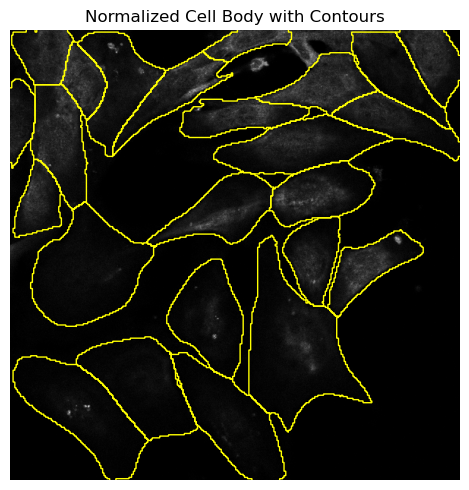

In [84]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np

# Görüntüyü normalize et (0–1 aralığına getir)
def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

# Normalize edilmiş cellbody görüntüsü
img_norm = normalize(img_cellbody)

# Çizim
fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(img_norm, cmap='gray')

# Sınırları çiz (örnek: sarı)
for region in measure.regionprops(masks_cellbody):
    for coords in measure.find_contours(masks_cellbody == region.label, 0.5):
        ax.plot(coords[:, 1], coords[:, 0], color='yellow', linewidth=1)

ax.set_title("Normalized Cell Body with Contours")
ax.axis('off')
plt.tight_layout()
plt.show()


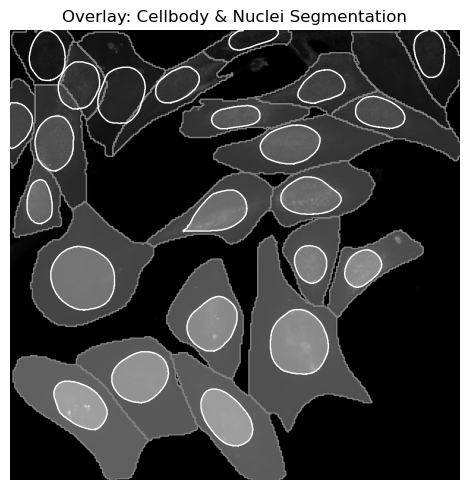

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

# Görüntüyü normalize et
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Maskelerin üzerine segmentasyon çizin
def plot_overlay(original_img, cellbody_mask, nuclei_mask, alpha=0.5):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Orijinal görüntüyü gri tonlarında göster
    ax.imshow(original_img, cmap='gray', alpha=1.0)

    # Hücre gövdesi segmentasyonunu (sadece kenarları) gri tonla çiz
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)

    # Çekirdek segmentasyonunu (sadece kenarları) beyaz tonla çiz
    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)

    # Hücre gövdesi segmentasyonunu şeffaf gri yaparak overlay et
    ax.imshow(cellbody_mask, cmap='gray', alpha=alpha)  # Gri renk, şeffaflık ile

    # Çekirdek segmentasyonunu şeffaf beyaz yaparak overlay et
    ax.imshow(nuclei_mask, cmap='gray', alpha=alpha/2)  # Beyaz renk, daha düşük şeffaflık

    ax.set_title("Overlay: Cellbody & Nuclei Segmentation")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Görüntüyü normalize et
img_norm = normalize(img_cellbody)

# Maskeleri overlay et (gri ve beyaz segmentasyon çizgileri, %50 şeffaflık)
plot_overlay(img_norm, masks_cellbody, masks_nuclei, alpha=0.5)


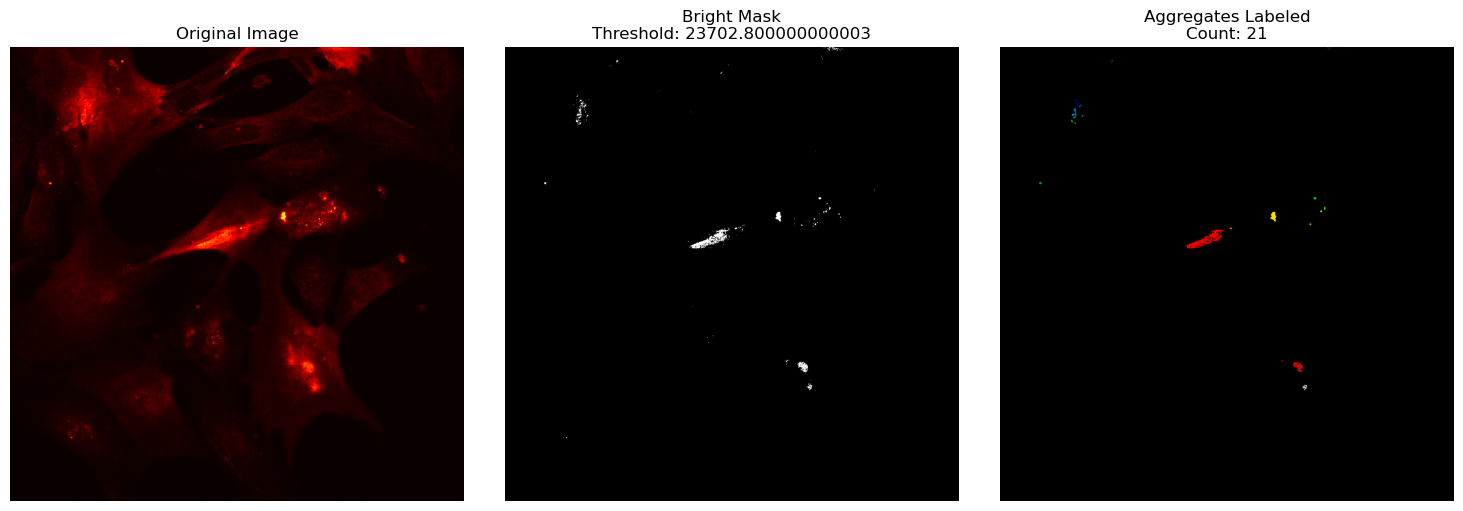

Total aggregations: 21


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology

# Eşik belirle: Parlak olan pikselleri yakalamak için
# threshold = int(img_aggregate.mean() + 6 * img_aggregate.std())


# from skimage.filters import threshold_otsu
# threshold = threshold_otsu(img_aggregate)

# from skimage.filters import threshold_li
# threshold = threshold_li(img_aggregate)

# from skimage.filters import threshold_triangle
# threshold = threshold_triangle(img_aggregate)

threshold = 0.4 * np.max(img_aggregate)



# Eşikle parlak noktaları seç
bright_spots = img_aggregate > threshold

# Küçük gürültüleri temizle
clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)

# Bağlantılı bileşenleri etiketle
labeled_mask = measure.label(clean_mask)
num_aggregations = labeled_mask.max()

# Görselleştir
plt.figure(figsize=(15, 5))

# 1. Orijinal görüntü
plt.subplot(1, 3, 1)
plt.imshow(img_aggregate, cmap='hot')
plt.axis('off')
plt.title('Original Image')

# 2. Binary maske (eşiklenmiş parlak bölgeler)
plt.subplot(1, 3, 2)
plt.imshow(bright_spots, cmap='gray')
plt.axis('off')
plt.title(f'Bright Mask\nThreshold: {threshold}')

# 3. Etiketlenmiş agregatlar
plt.subplot(1, 3, 3)
plt.imshow(labeled_mask, cmap='nipy_spectral')
plt.axis('off')
plt.title(f'Aggregates Labeled\nCount: {num_aggregations}')

plt.tight_layout()
plt.show()

print(f"Total aggregations: {num_aggregations}")


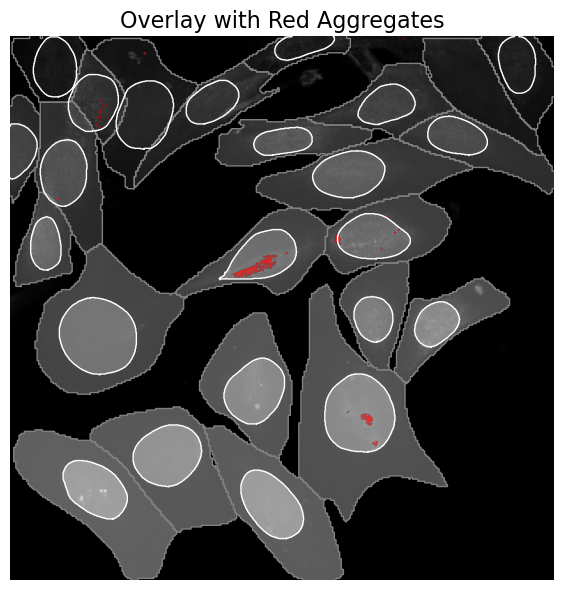

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_overlay_with_red_aggregates(original_img, cellbody_mask, nuclei_mask, aggregate_mask, alpha=0.5):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Ana görüntü (gri)
    ax.imshow(original_img, cmap='gray', alpha=1.0)

    # Hücre sınırları (gri çizgi)
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)

    # Çekirdek sınırları (beyaz çizgi)
    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)

    # Maskeler (gri ve beyaz)
    ax.imshow(cellbody_mask, cmap='gray', alpha=alpha)
    ax.imshow(nuclei_mask, cmap='gray', alpha=alpha/2)

    # Kırmızı agregat maske (0 olan yerleri gizle)
    red_overlay = np.zeros((*aggregate_mask.shape, 4))  # RGBA
    red_overlay[aggregate_mask > 0] = [1, 0, 0, 0.7]  # kırmızı, %70 opak

    ax.imshow(red_overlay)

    ax.set_title("Overlay with Red Aggregates", fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# normalize edilmiş görüntü
img_norm = normalize(img_cellbody)

# aggregate_mask: clean_mask veya bright_spots olabilir
plot_overlay_with_red_aggregates(img_norm, masks_cellbody, masks_nuclei, clean_mask)


2025-05-07 13:54:17,012 [INFO] WRITING LOG OUTPUT TO /Users/demir/.cellpose/run.log
2025-05-07 13:54:17,013 [INFO] 
cellpose version: 	4.0.2.dev5+g636f0ee 
platform:       	darwin 
python version: 	3.10.17 
torch version:  	2.6.0
2025-05-07 13:54:17,026 [INFO] ** TORCH MPS version installed and working. **
2025-05-07 13:54:17,027 [INFO] >>>> using CPU
2025-05-07 13:54:17,027 [INFO] >>>> using CPU
2025-05-07 13:54:18,117 [INFO] >>>> loading model /Users/demir/.cellpose/models/cpsam
2025-05-07 13:54:19,348 [INFO] reading tiff with 36 planes


100%|██████████| 36/36 [00:00<00:00, 574.11it/s]

img shape: (9, 4, 1024, 1024)
Channel 1 shape: (9, 1024, 1024)


Channel 3 shape: (9, 1024, 1024)


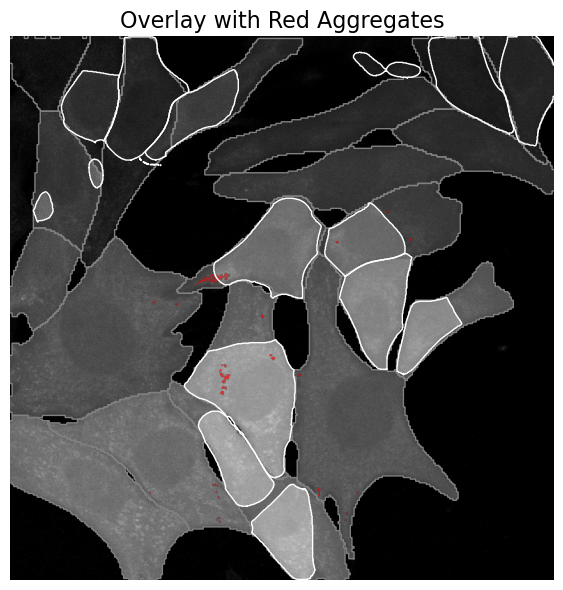

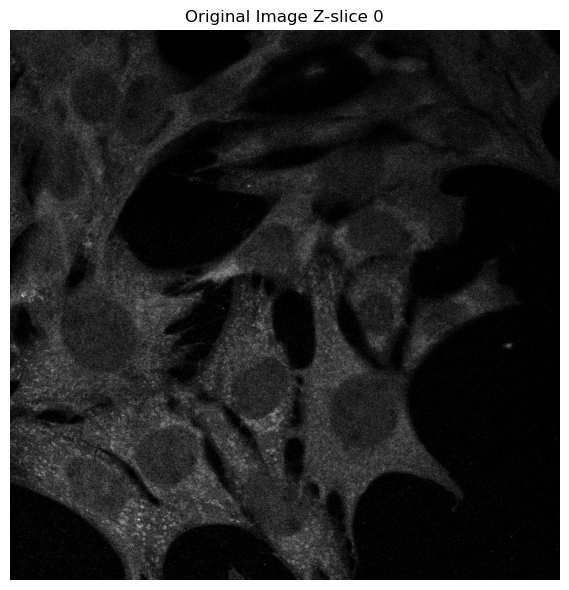

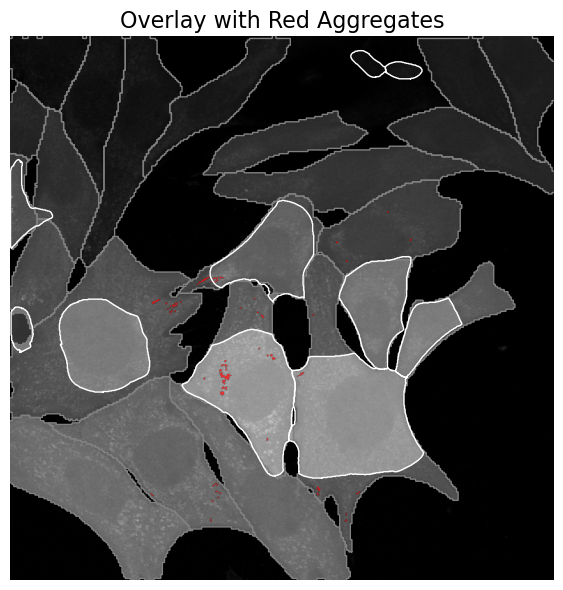

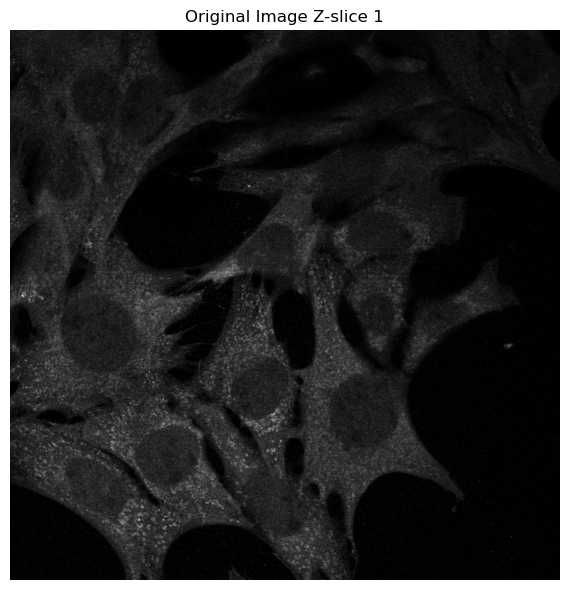

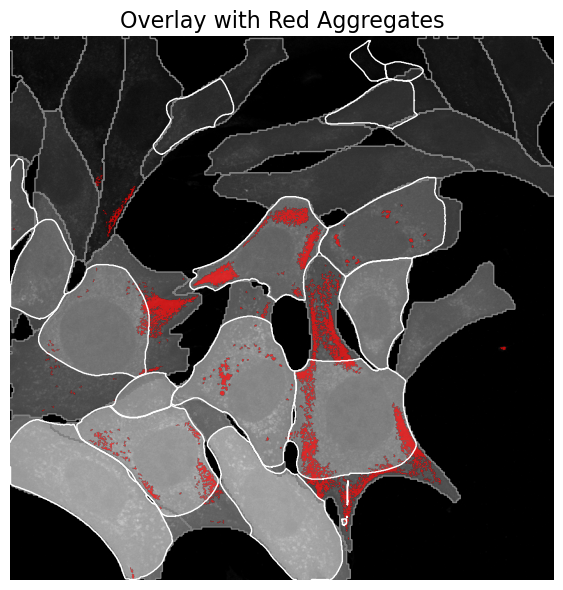

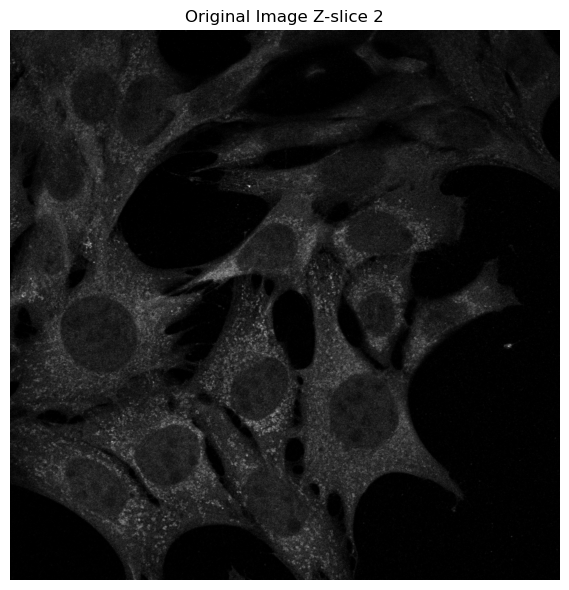

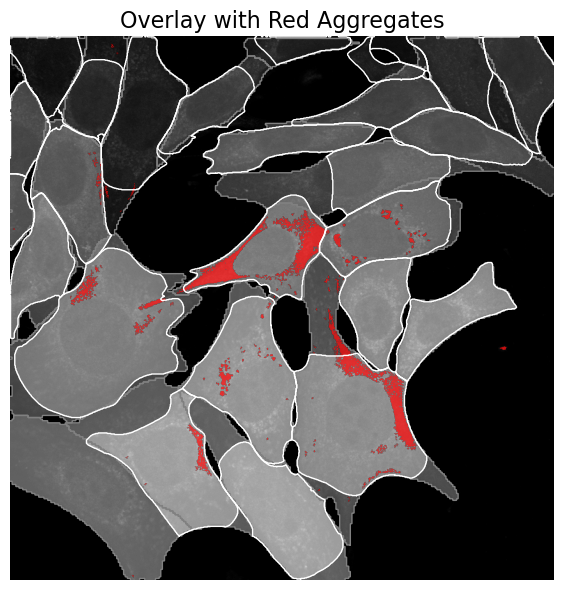

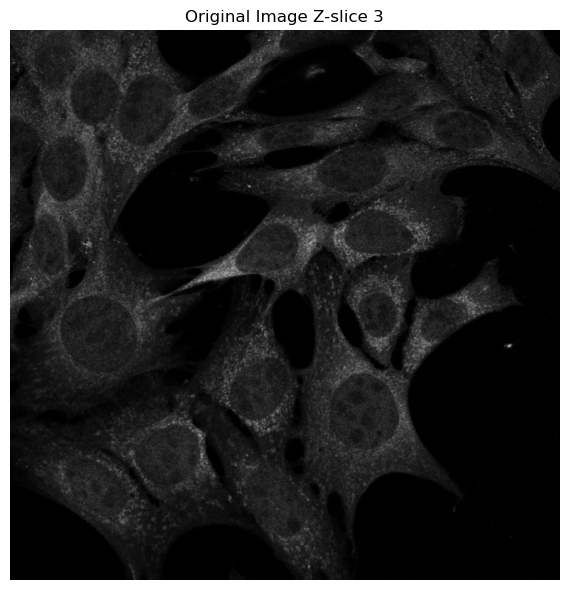

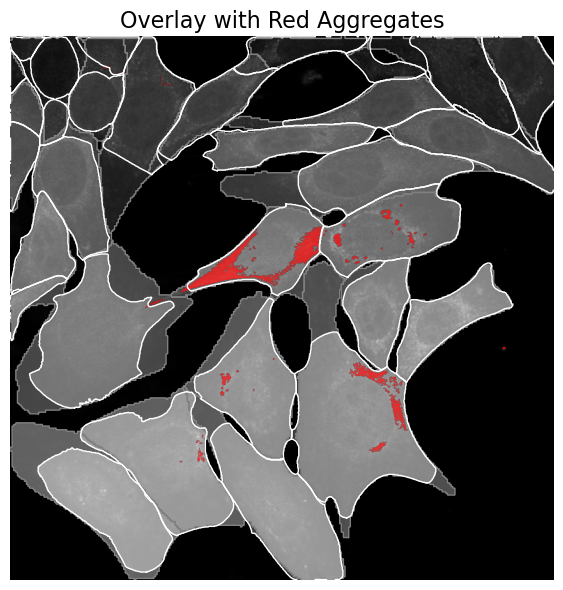

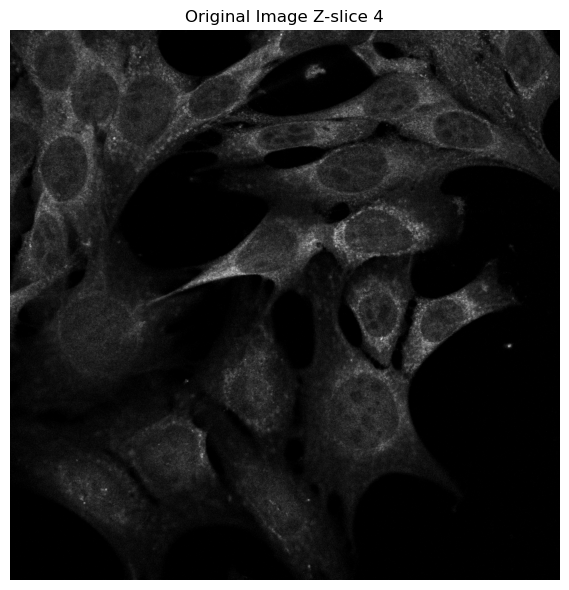

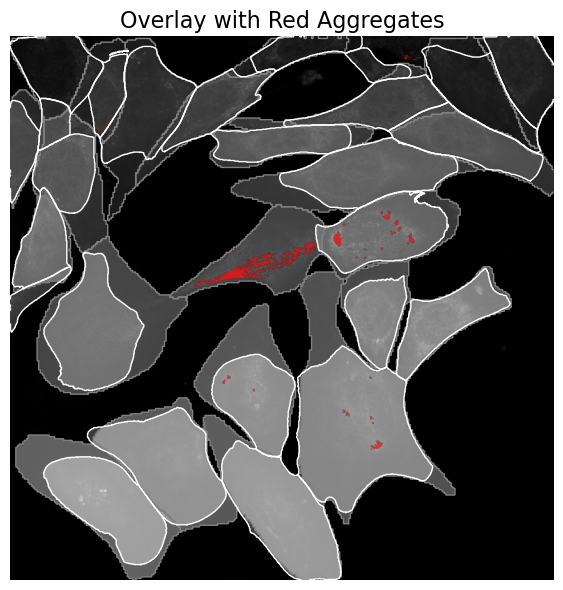

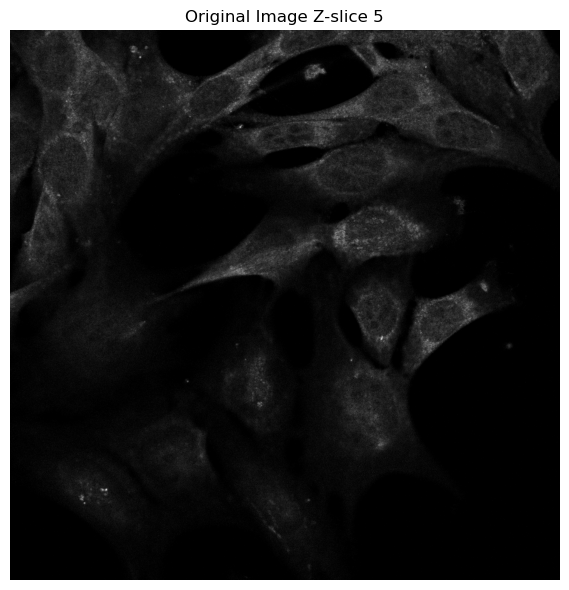

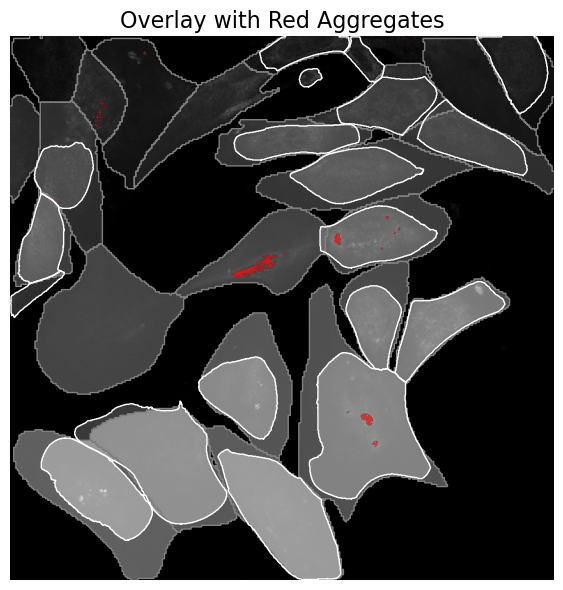

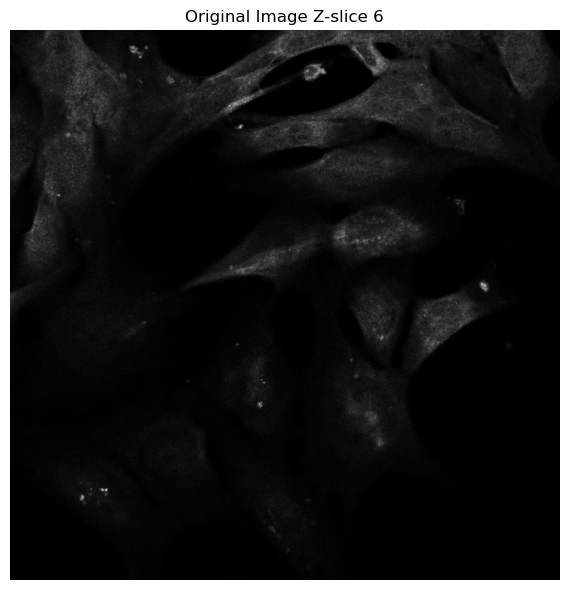

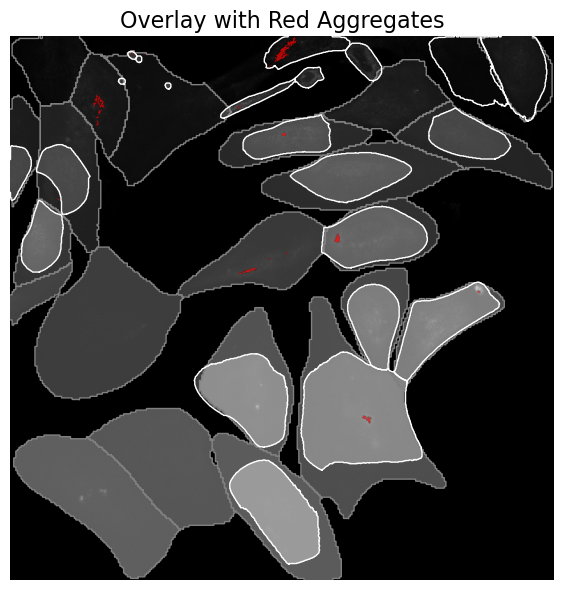

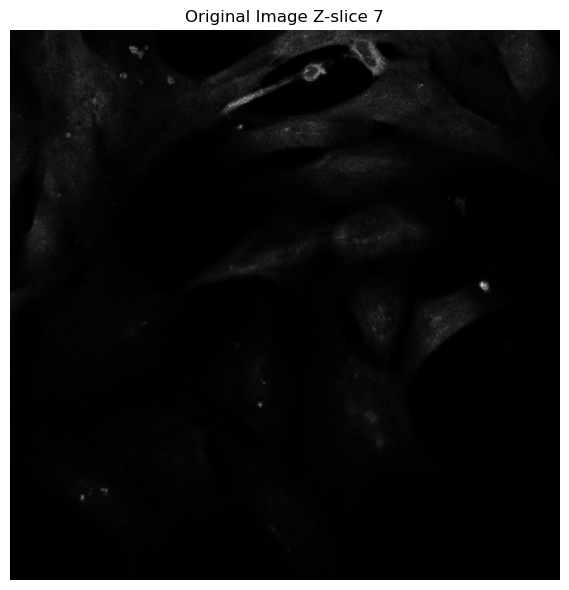

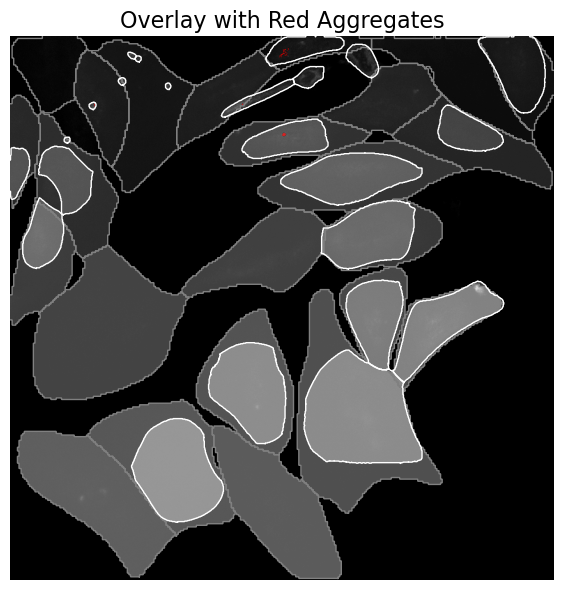

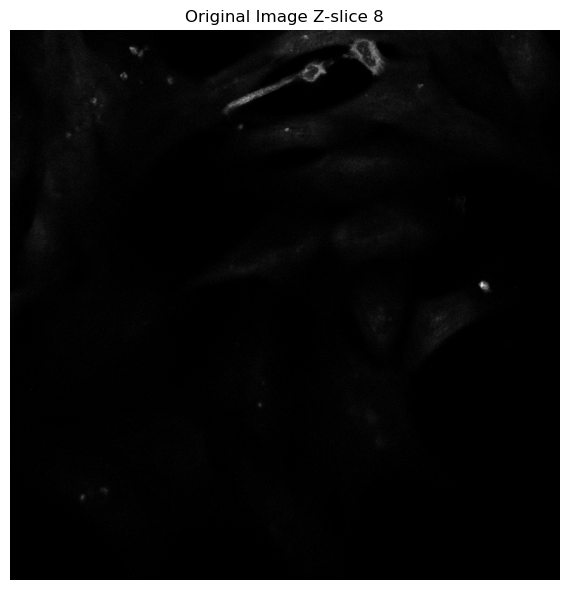

In [5]:
import numpy as np
from cellpose import models, core, io, plot
from skimage import measure, morphology
import matplotlib.pyplot as plt

# Logger setup
io.logger_setup()

# Check for GPU access
if core.use_gpu() == False:
    raise ImportError("No GPU access, change your runtime")

# Load model
model = models.CellposeModel()

# Input image file
file_name = f"/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/tif_deneme_1.tif"
img = io.imread(file_name)  # img shape: (Z, Channels, Height, Width)
print(f'img shape: {img.shape}')

# Normalize function
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Function to process each Z-slice for a given channel
def process_channel(img, channel_idx, diameter, threshold_factor=0.4):
    channel_img = img[:, channel_idx, :, :]
    print(f'Channel {channel_idx} shape: {channel_img.shape}')
    
    # Create an empty list to hold the masks for each Z-slice
    masks = []
    
    for z_slice in range(channel_img.shape[0]):
        slice_img = channel_img[z_slice, :, :]
        
        masks_z, _, _ = model.eval(
            slice_img,
            batch_size=8,
            flow_threshold=0.4,
            cellprob_threshold=0.0,
            diameter=diameter,
            normalize={"tile_norm_blocksize": 0}
        )
        masks.append(masks_z)
    
    return masks

# Process nuclei (Channel 1)
nuclei_masks = process_channel(img, 1, diameter=30)

# Process cell bodies (Channel 3)
cellbody_masks = process_channel(img, 3, diameter=100)

# Process aggregates (Channel 2)
def process_aggregates(img):
    aggregate_masks = []
    for z_slice in range(img.shape[0]):
        slice_img = img[z_slice, 2, :, :]  # Channel 2 for aggregates
        threshold = 0.4 * np.max(slice_img)
        bright_spots = slice_img > threshold
        clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)
        aggregate_masks.append(clean_mask)
    return aggregate_masks

aggregate_masks = process_aggregates(img)

# Function to plot overlay with red aggregates
def plot_overlay_with_red_aggregates(original_img, cellbody_mask, nuclei_mask, aggregate_mask, alpha=0.5):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.imshow(original_img, cmap='gray', alpha=1.0)

    # Cell body and nuclei boundaries
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)
    
    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)
    
    # Overlay masks with transparency
    ax.imshow(cellbody_mask, cmap='gray', alpha=alpha)
    ax.imshow(nuclei_mask, cmap='gray', alpha=alpha / 2)
    
    # Red aggregates overlay
    red_overlay = np.zeros((*aggregate_mask.shape, 4))  # RGBA
    red_overlay[aggregate_mask > 0] = [1, 0, 0, 0.7]  # Red with 70% opacity
    ax.imshow(red_overlay)

    ax.set_title("Overlay with Red Aggregates", fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Iterate over all Z-slices and create the required visualizations
for z_slice in range(img.shape[0]):
    img_norm = normalize(img[z_slice, 3, :, :])  # Normalize cell body image
    plot_overlay_with_red_aggregates(img_norm, cellbody_masks[z_slice], nuclei_masks[z_slice], aggregate_masks[z_slice])

    # Original image visualization
    plt.figure(figsize=(12, 6))
    plt.imshow(img[z_slice, 3, :, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Original Image Z-slice {z_slice}")
    plt.tight_layout()
    plt.show()


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_overlay_with_counts(original_img, cellbody_mask, nuclei_mask, aggregate_mask, cellbody_count, nuclei_count, aggregate_count, alpha=0.5):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # Yanyana 2 görsel için

    # 1. Orijinal görüntü
    ax[0].imshow(original_img, cmap='gray', alpha=1.0)
    ax[0].set_title("Original Image", fontsize=16)
    ax[0].axis('off')

    # 2. Overlay görüntü (cellbody, nuclei ve aggregates)
    ax[1].imshow(original_img, cmap='gray', alpha=1.0)

    # Hücre gövdesi sınırlarını çiz (gri)
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax[1].plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)

    # Çekirdek sınırlarını çiz (beyaz)
    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax[1].plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)

    # Aggregatelerin kırmızı overlay'i
    red_overlay = np.zeros((*aggregate_mask.shape, 4))  # RGBA
    red_overlay[aggregate_mask > 0] = [1, 0, 0, 0.7]  # Kırmızı, %70 opak

    ax[1].imshow(red_overlay)

    ax[1].set_title(f"Overlay with Red Aggregates\nAggregates: {aggregate_count}\nCell Bodies: {cellbody_count}\nNuclei: {nuclei_count}", fontsize=16)
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

    



In [12]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

# Normalize fonksiyonu
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Overlay ve sayıların gösterildiği fonksiyon
def plot_overlay_with_counts(original_img, cellbody_mask, nuclei_mask, aggregate_mask, 
                             cellbody_count, nuclei_count, aggregate_count, alpha=0.5):
    fig, ax = plt.subplots(figsize=(15, 6))

    # Sol tarafta orijinal görüntü
    ax.subplot(1, 2, 1)
    ax.imshow(original_img, cmap='gray', alpha=1.0)
    ax.set_title("Original Image", fontsize=14)
    ax.axis('off')
    
    # Sağ tarafta overlay
    ax.subplot(1, 2, 2)
    ax.imshow(original_img, cmap='gray', alpha=1.0)

    # Cell body ve nuclei sınırlarını çiz
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)

    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)

    # Maskeleri şeffaflıkla overlay et
    ax.imshow(cellbody_mask, cmap='gray', alpha=alpha)
    ax.imshow(nuclei_mask, cmap='gray', alpha=alpha / 2)
    
    # Kırmızı agregat overlay
    red_overlay = np.zeros((*aggregate_mask.shape, 4))  # RGBA
    red_overlay[aggregate_mask > 0] = [1, 0, 0, 0.7]  # Kırmızı, %70 opaklık
    ax.imshow(red_overlay)

    ax.set_title(f"Overlay with Red Aggregates\n"
                 f"Cells: {cellbody_count}, Nuclei: {nuclei_count}, Aggregates: {aggregate_count}", fontsize=16)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Z-slice'lar üzerinde iterasyon
for z_slice in range(img.shape[0]):
    img_norm = normalize(img[z_slice, 3, :, :])  # Hücre gövdesi görüntüsünü normalize et

    # Maskeleri oluştur (örnek olarak burada `cellbody_masks`, `nuclei_masks` ve `aggregate_masks` kullanılmıştır)
    cellbody_mask = masks_cellbody[z_slice]
    nuclei_mask = masks_nuclei[z_slice]
    aggregate_mask = clean_mask[z_slice]

    # Hücre, çekirdek ve agregat sayısı
    cellbody_count = int(cellbody_mask.max())
    nuclei_count = int(nuclei_mask.max())
    aggregate_count = int(aggregate_mask.max())

    # Overlay ve sayılarla birlikte görselleştirme
    plot_overlay_with_counts(img_norm, cellbody_mask, nuclei_mask, aggregate_mask, 
                             cellbody_count, nuclei_count, aggregate_count)


NameError: name 'masks_cellbody' is not defined